In [23]:
import numpy as np
import pandas as pd
import scipy.spatial
import scipy.signal
import scipy.stats
from scipy.signal import hilbert
from matplotlib import pyplot as plt
import scienceplots
plt.style.use('science')
plt.rcParams['text.usetex'] = False

In [5]:
import multiSyncPy as ms
from multiSyncPy import synchrony_metrics as sm
from multiSyncPy import data_generation as dg
from multiSyncPy import visualisations as vs

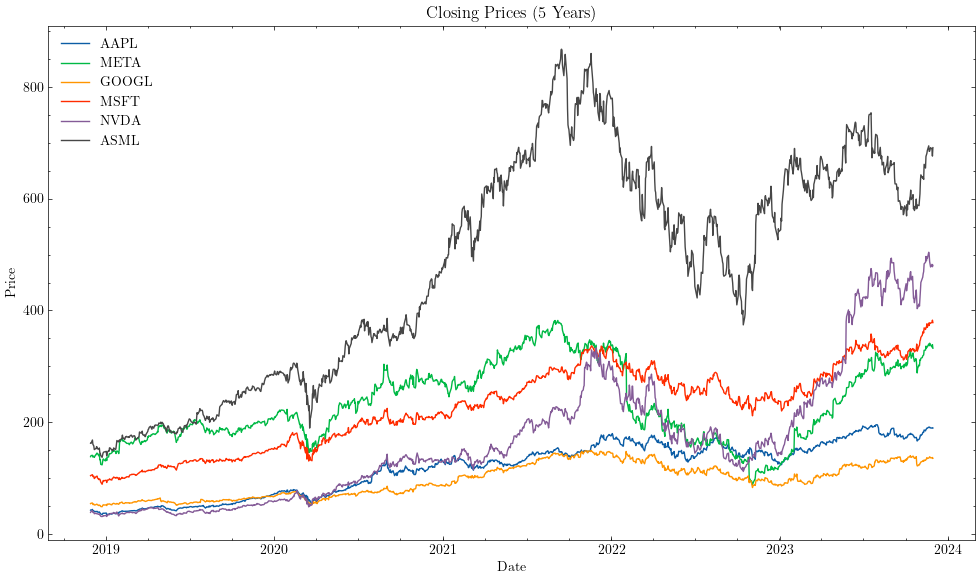

In [6]:
# Load & pivot closing prices
data = pd.read_csv("stock_details_5_years.csv", parse_dates=["Date"])
ts_array = (
    data
    .pivot(index="Date", columns="Company", values="Close")
    .loc[:, ["AAPL","META","GOOGL","MSFT","NVDA","ASML"]]
    .dropna()
)

# Min–Max normalize each series to [0, 100]
min_vals = ts_array.min()
max_vals = ts_array.max()
scaled = (ts_array - min_vals) / (max_vals - min_vals) * 100
ts_array_scaled = scaled.values.T

# Plot 1: Closing Prices
plt.figure(figsize=(10, 6))
for ticker in ts_array.columns:
    plt.plot(ts_array.index, ts_array[ticker], label=ticker)
plt.title("Closing Prices (5 Years)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc="upper left", frameon=False)
plt.tight_layout()
# Save to PNG at 300 dpi
plt.savefig("raw_closing_prices.png", dpi=300, bbox_inches="tight")
plt.show()

ts_array = ts_array.values.T


Multidimensional Recurrence Quantification Analysis (mdRQA)



In [8]:
radius = 1

# Multidimensional Recurrence Quantification Analysis (mdRQA)
#radius = 1
rec_mat     = sm.recurrence_matrix(ts_array_scaled, radius=radius)    
rec_metrics = sm.rqa_metrics(rec_mat)         
print("mdRQA (rec, det, mean_len, max_len):", rec_metrics)

mdRQA (rec, det, mean_len, max_len): (0.13021894560572084, 0.9796421841916121, 16.034574053885688, 799)


Symbolic Entropy: 2.886210331660156


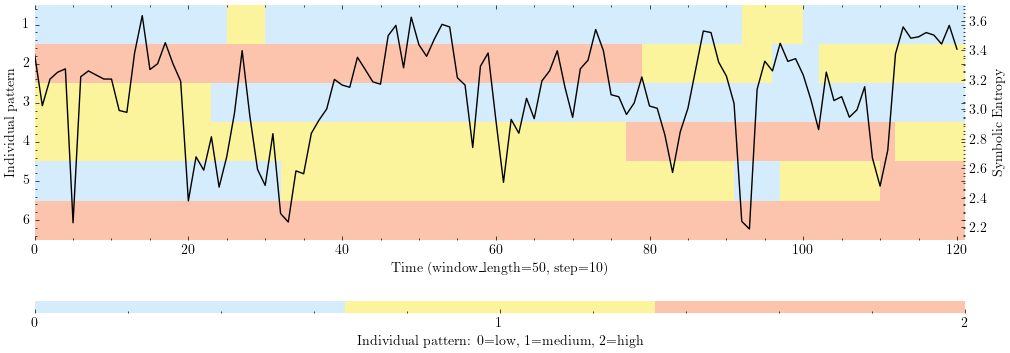

In [9]:
# Symbolic Entropy
sym_entropy = sm.symbolic_entropy(ts_array)
print("Symbolic Entropy:", sym_entropy)

# Choose a window length and step
window_length = 50
step = 10  # non‐overlapping if step == window_length

# Plot windowed symbolic entropy
fig = vs.plot_entropy(
    data=ts_array,
    window_length=window_length,
    step=step,
    figsize=(12, 4),
    custom_cols=(['#D4ECFC', '#FCF49C', '#FCC4AC'], 'black'),
    gradient=False
)

# 6. Display (and optionally save)
plt.show()
fig.savefig("symbolic_entropy.png", dpi=300, bbox_inches="tight")

In [12]:
# Coherence-Measures
coh         = sm.coherence_team(ts_array)
print("Coherence:", coh)

Coherence: 0.4799491296515069


In [13]:
# Sum-normalized CSD
csd         = sm.sum_normalized_csd(ts_array)

print("Sum‐normalized CSD:", csd)

Sum‐normalized CSD: 0.5915145184054162


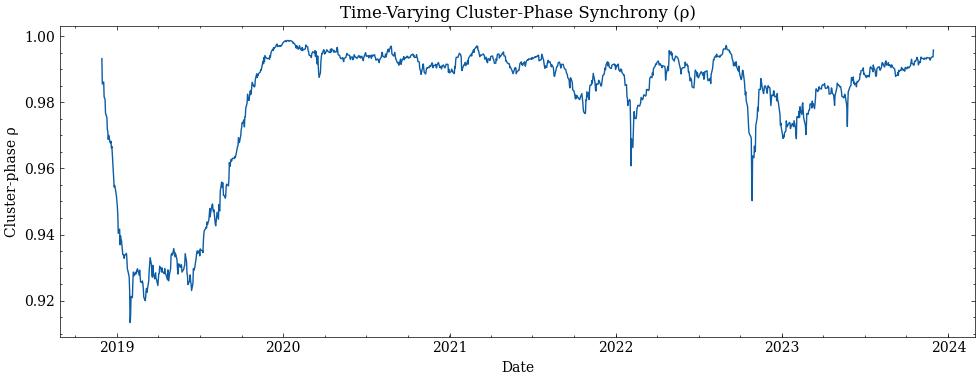

Overall cluster-phase ρ: 0.9808642559332896


In [25]:
# Compute instantaneous phase via Hilbert transform
phases = np.angle(hilbert(ts_array, axis=1))

# Compute cluster-phase synchrony ρ
rho_time, rho_overall = sm.rho(phases)

# Plot the time-varying ρ
plt.figure(figsize=(10,4))
plt.plot(scaled.index, rho_time)
plt.xlabel("Date")
plt.ylabel("Cluster-phase ρ")
plt.title("Time-Varying Cluster-Phase Synchrony (ρ)")
plt.tight_layout()
plt.savefig("clusterphaserho.png", dpi=300, bbox_inches="tight")
plt.show()

# Print the overall ρ
print("Overall cluster-phase ρ:", rho_overall)

In [33]:
# Create a sample of 100 “recordings” by tiling and adding noise
n_recordings = 100
noise_std     = 1

sample = np.tile(
    ts_array[np.newaxis, ...], 
    (n_recordings, 1, 1)
) + np.random.normal(
    loc=0, 
    scale=noise_std, 
    size=(n_recordings, ts_array.shape[0], ts_array.shape[1])
)

# Compute instantaneous phase for each recording
# (hilbert along the time axis, axis=2)
sample_phases = np.angle(hilbert(sample, axis=2))

# Perform the Kuramoto weak-null test
p_val, t_stat, df = sm.kuramoto_weak_null(sample_phases)

print(f"Kuramoto weak-null test → p = {p_val:.3e}, t = {t_stat:.2f}, df = {df}")

Kuramoto weak-null test → p = 0.000e+00, t = 241470.87, df = 99


In [31]:
# Print all results
print("mdRQA (rec, det, mean_len, max_len):", rec_metrics)
print("Symbolic Entropy:", sym_entropy)
print("Coherence:", coh)
print("Sum‐normalized CSD:", csd)
print("Overall cluster‐phase ρ:", rho_overall)
print(f"Kuramoto weak‐null test → p = {p_val:.3e}, t = {t_stat:.2f}, df = {df}")

mdRQA (rec, det, mean_len, max_len): (0.13021894560572084, 0.9796421841916121, 16.034574053885688, 799)
Symbolic Entropy: 2.886210331660156
Coherence: 0.4799491296515069
Sum‐normalized CSD: 0.5915145184054162
Overall cluster‐phase ρ: 0.9808642559332896
Kuramoto weak‐null test → p = 0.000e+00, t = 263988.64, df = 99
